In [1]:
from IPython.core.display import HTML
HTML(open("custom.css", "r").read())

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#From-Transistors-to-ALUs-With-Skywater" data-toc-modified-id="From-Transistors-to-ALUs-With-Skywater-1">From Transistors to ALUs With Skywater</a></span><ul class="toc-item"><li><span><a href="#Installing-Some-Tools" data-toc-modified-id="Installing-Some-Tools-1.1">Installing Some Tools</a></span></li><li><span><a href="#Getting-the-Skywater-PDK" data-toc-modified-id="Getting-the-Skywater-PDK-1.2">Getting the Skywater PDK</a></span></li><li><span><a href="#Some-Infrastructure" data-toc-modified-id="Some-Infrastructure-1.3">Some Infrastructure</a></span></li><li><span><a href="#The-Simplest:-the-Inverter" data-toc-modified-id="The-Simplest:-the-Inverter-1.4">The Simplest: the Inverter</a></span></li><li><span><a href="#The-Universal:-the-NAND-Gate" data-toc-modified-id="The-Universal:-the-NAND-Gate-1.5">The Universal: the NAND Gate</a></span></li><li><span><a href="#One-or-the-Other:-the-XOR-Gate" data-toc-modified-id="One-or-the-Other:-the-XOR-Gate-1.6">One or the Other: the XOR Gate</a></span></li><li><span><a href="#No,-It's-Not-a-Snake:-The-Adder" data-toc-modified-id="No,-It's-Not-a-Snake:-The-Adder-1.7">No, It's Not a Snake: The Adder</a></span></li><li><span><a href="#Fragments-of-Memory:-Latches,-Flip-Flops-and-Registers" data-toc-modified-id="Fragments-of-Memory:-Latches,-Flip-Flops-and-Registers-1.8">Fragments of Memory: Latches, Flip-Flops and Registers</a></span></li><li><span><a href="#The-Simplest-State-Machine:-the-Counter" data-toc-modified-id="The-Simplest-State-Machine:-the-Counter-1.9">The Simplest State Machine: the Counter</a></span></li><li><span><a href="#Bonus:-an-ALU" data-toc-modified-id="Bonus:-an-ALU-1.10">Bonus: an ALU</a></span></li><li><span><a href="#Extra-Bonus:-a-Down-Counter" data-toc-modified-id="Extra-Bonus:-a-Down-Counter-1.11">Extra Bonus: a Down Counter</a></span></li><li><span><a href="#End-of-the-Line" data-toc-modified-id="End-of-the-Line-1.12">End of the Line</a></span></li></ul></li></ul></div>

# From Transistors to ALUs With Skywater

[Google and SkyWater Technology](https://woset-workshop.github.io/PDFs/2020/a03.pdf) are cooperating to provide open-source hardware designers with a way to build custom ASICs. Part of this effort is the release of the [SkyWater PDK](https://github.com/google/skywater-pdk) which describes the parameters for a 130nm CMOS process. I thought it might be fun to simulate a few logic gates in SPICE using this PDK.

## Installing Some Tools

[This repo](https://github.com/bluecmd/learn-sky130/blob/main/schematic/xschem/getting-started.md) provided some guidance when I first started investigating the PDK, but it uses external tools like [XSCHEM](http://repo.hu/projects/xschem/) (for schematic capture) and [GAW](https://gaw.tuxfamily.org/linux/gaw.php) (for displaying waveforms). To make my work easier to replicate and distribute, I wanted everything to be done in a Jupyter notebook. It wasn't immediately apparent how I would integrate XSCHEM/GAW into a notebook and [schematics shouldn't be used in polite company](https://www.youtube.com/watch?v=WErQYI2A36M&list=PLy2022BX6EsqLkQy1EmXjVnauOH3FSHTV&index=3&t=257s) any way, so I took a more Python-centric approach and used these tools:

* [ngspice](http://ngspice.sourceforge.net/): An open-source SPICE simulator.
* [SciPy bundle](https://www.scipy.org/index.html): General-purpose Python libraries for handling data.
* [SKiDL](https://github.com/xesscorp/skidl): Used to describe circuitry using Python code.
* [PySpice](https://github.com/FabriceSalvaire/PySpice): A Python interface between SKiDL and ngspice.

Pre-built versions of ngspice are available for Windows and MacOS. For linux, I got the latest ngspice files (version 33) from [here](https://sourceforge.net/projects/ngspice/files/ng-spice-rework/33/), unpacked it into the `ngspice-33` directory, and built it using the instructions in the INSTALL file:

```bash
$ cd ngspice-33
$ mkdir release
$ cd release
$ ../configure --with-x --enable-xspice --disable-debug --enable-cider --with-readline=yes --enable-openmp
$ make 2>&1 | tee make.log
$ sudo make install
```

Installing the SciPy tools was also easy since I already had Python:
```bash
$ pip install matplotlib numpy pandas jupyter 
```

I couldn't use the PyPi versions of PySpice and SKiDL because they had to be modified to make them work with the Skywater PDK. If you want to run this notebook, you'll need to install the development versions of those from GitHub:

```bash
$ pip install git+https://github.com/xesscorp/PySpice
$ pip install git+https://github.com/xesscorp/skidl@development
```

Once all these tools were installed, I imported them into this notebook:

In [2]:
import pandas as pd              # For data frames.
import matplotlib.pyplot as plt  # For plotting.
from skidl.pyspice import *      # For describing circuits and interfacing to ngspice.

## Getting the Skywater PDK

With the tooling in place, it was time to get the Skywater PDK. If I wanted to wait a *long time*, I could install the entire PDK like this:
```bash
$ git clone --recurse-submodules https://github.com/google/skywater-pdk
```

But I don't need *everything*, just the latest SPICE models for the device primitives, so the following command is much quicker: 

```bash
$ git clone --recurse-submodules=libraries/sky130_fd_pr/latest https://github.com/google/skywater-pdk
```

Even with a stripped-down repo, there's a lot of stuff in there. The [Skywater documentation](https://skywater-pdk.readthedocs.io/en/latest/index.html) provides some guidance, but there are a lot of sections that just contain **TODO**. Poking about in the PDK led me to these directories of device information files as decribed [here](https://skywater-pdk.readthedocs.io/en/latest/rules/device-details.html):

In [3]:
!ls -F ~/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/cells/

cap_mim_m3/				      esd_rf_diode_pd2nw_11v0/
cap_var_hvt/				      esd_rf_diode_pw2nd_11v0/
cap_var_lvt/				      esd_rf_nfet_20v0_hbm/
cap_vpp_01p8x01p8_m1m2_noshield/	      esd_rf_nfet_20v0_iec/
cap_vpp_02p4x04p6_m1m2_noshield/	      ind_03/
cap_vpp_02p7x06p1_m1m2m3m4_shieldl1/	      ind_05/
cap_vpp_02p7x11p1_m1m2m3m4_shieldl1/	      nfet_01v8/
cap_vpp_02p7x21p1_m1m2m3m4_shieldl1/	      nfet_01v8_lvt/
cap_vpp_02p7x41p1_m1m2m3m4_shieldl1/	      nfet_03v3_nvt/
cap_vpp_02p9x06p1_m1m2m3m4_shieldl1/	      nfet_05v0_nvt/
cap_vpp_03p9x03p9_m1m2_shieldl1_floatm3/      nfet_20v0/
cap_vpp_04p4x04p6_l1m1m2_noshield/	      nfet_20v0_iso/
cap_vpp_04p4x04p6_l1m1m2_shieldpo_floatm3/    nfet_20v0_nvt/
cap_vpp_04p4x04p6_m1m2m3_shieldl1/	      nfet_20v0_nvt_iso/
cap_vpp_04p4x04p6_m1m2m3_shieldl1m5_floatm4/  nfet_20v0_reverse_iso/
cap_vpp_04p4x04p6_m1m2_noshield/	      nfet_20v0_zvt/
cap_vpp_04p4x04p6_m1m2_shieldl1/	      nfet_g5v0d10v5/
cap_vpp_05p9x05p9_m1m2m3m4_shieldl1/	      nfet_g5v0d16v0/
cap_v

For my purposes, I only needed a simple NFET and PFET to build some logic gates. I figured 1.8V versions of these would be found in the `nfet_01v8` and `pfet_01v8` subdirectories, but I wasn't expecting all these files:

In [4]:
!ls -F ~/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/cells/nfet_01v8

sky130_fd_pr__nfet_01v8_aM02W1p65L0p15.cdl*
sky130_fd_pr__nfet_01v8_aM02W1p65L0p15.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W1p65L0p18.cdl*
sky130_fd_pr__nfet_01v8_aM02W1p65L0p18.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W1p65L0p25.cdl*
sky130_fd_pr__nfet_01v8_aM02W1p65L0p25.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W3p00L0p15.cdl*
sky130_fd_pr__nfet_01v8_aM02W3p00L0p15.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W3p00L0p18.cdl*
sky130_fd_pr__nfet_01v8_aM02W3p00L0p18.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W3p00L0p25.cdl*
sky130_fd_pr__nfet_01v8_aM02W3p00L0p25.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W5p00L0p15.cdl*
sky130_fd_pr__nfet_01v8_aM02W5p00L0p15.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W5p00L0p18.cdl*
sky130_fd_pr__nfet_01v8_aM02W5p00L0p18.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM02W5p00L0p25.cdl*
sky130_fd_pr__nfet_01v8_aM02W5p00L0p25.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM04W1p65L0p15.cdl*
sky130_fd_pr__nfet_01v8_aM04W1p65L0p15.netlist.tsv*
sky130_fd_pr__nfet_01v8_aM04W1p65L0p18.c

After some further poking about and reading, I categorized the files as follows:

* Any file ending in `.cdl` seems to be associated with Cadence. Since I'll never have the money to run their software, I can ignore these and the associated `.tsv` files.
* Files with names containing `_tt_`, `_ff_`, `_fs_`, `_sf_`, or `_ss_` refer to *[process corners](http://anysilicon.com/understanding-process-corner-corner-lots/)* where variations in the semiconductor fabrication process lead to NMOS/PMOS transistors that have typical, fast or slow switching characteristics.
* Files ending with `.pm3.spice` contain most of the device parameters for a particular corner. These files are included inside an associated `corner.spice` file that makes a small adjustment to the parameters. Both these files are used for simulating transistors at a given process corner.
* Files ending with `leak.pm3.spice` and `leak.corner.spice` are similar to the previous files, but are probably used for simulating transistor leakage currents.
* Many of the `.spice` files contain multiple transistor models with differing parameters that are dependent on the length and width of the transistor gate. The file ending with `.bins.csv` contains a list of the supported transistor sizes. Some of the 1.8V NMOS and PMOS transistor dimensions are shown below:

In [5]:
import pandas as pd
nfet_sizes = pd.read_table("~/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/cells/nfet_01v8/sky130_fd_pr__nfet_01v8.bins.csv", delimiter=",")
pfet_sizes = pd.read_table("~/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/cells/pfet_01v8/sky130_fd_pr__pfet_01v8.bins.csv", delimiter=",")
pd.concat((nfet_sizes, pfet_sizes), axis=1)

,device,bin,W,L,device,bin,W,L
0,sky130_fd_pr__nfet_01v8,0,1.26,0.15,sky130_fd_pr__pfet_01v8,0.0,1.26,0.15
1,sky130_fd_pr__nfet_01v8,1,1.68,0.15,sky130_fd_pr__pfet_01v8,1.0,1.68,0.15
2,sky130_fd_pr__nfet_01v8,2,1.00,1.00,sky130_fd_pr__pfet_01v8,2.0,1.00,1.00
3,sky130_fd_pr__nfet_01v8,3,1.00,2.00,sky130_fd_pr__pfet_01v8,3.0,1.00,2.00
4,sky130_fd_pr__nfet_01v8,4,1.00,4.00,sky130_fd_pr__pfet_01v8,4.0,1.00,4.00
...,...,...,...,...,...,...,...,...
58,sky130_fd_pr__nfet_01v8,58,0.61,0.15,NaN,NaN,NaN,NaN
59,sky130_fd_pr__nfet_01v8,59,0.65,0.15,NaN,NaN,NaN,NaN
60,sky130_fd_pr__nfet_01v8,60,0.65,0.18,NaN,NaN,NaN,NaN
61,sky130_fd_pr__nfet_01v8,61,0.65,0.25,NaN,NaN,NaN,NaN


Knowing where the device files are and what they contain is great, but how do I actually *use* them? It turns out there is a master library file: `skywater-pdk/libraries/sky130_fd_pr/latest/models/sky130.lib.spice`. Internally, this file is divided into nine *sections* that cover the five process corners (`tt`, `ff`, `fs`, `sf`, `ss`) as well as four additional corners for the low/high variations in resistor and capacitor values (`hh`, `hl`, `lh`, `ll`). I'm only interested in using some typical FETs, so I can load that section into a SKiDL library like so:

In [6]:
# Select a particular corner using tt, ff, fs, sf, ss, hh, hl, lh, ll.
corner = "tt"  # Use typical transistor models.

# Create a SKiDL library for the Skywater devices at that process corner.
sky_lib = SchLib(
    "/home/devb/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/models/sky130.lib.spice",
    lib_section=corner,  # Load the transistor models for this corner.
    recurse=True,  # The master lib includes sublibraries, so recurse thru them to load everything.
)

print(sky_lib)  # Print the list of devices in the library.

Bad element line, looking for word 1/2:
include "sky130_fd_pr__esd_nfet_05v0_nvt.pm3"
        ^
Parse error on:
include "sky130_fd_pr__esd_nfet_05v0_nvt.pm3"
Problem parsing /home/devb/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/models/r+c/../r+c.mrp1monte.spice - list assignment index out of range
Empty Spice file: /home/devb/tmp/skywater-pdk/libraries/sky130_fd_pr/latest/models/head.spice


sky130_fd_pr__rf_nfet_01v8_bm02w1p65l0p15: 
sky130_fd_pr__rf_nfet_01v8_bm04w1p65l0p15: 
sky130_fd_pr__rf_nfet_01v8_bm02w1p65l0p18: 
sky130_fd_pr__rf_nfet_01v8_bm04w1p65l0p18: 
sky130_fd_pr__rf_nfet_01v8_bm02w1p65l0p25: 
sky130_fd_pr__rf_nfet_01v8_bm04w1p65l0p25: 
sky130_fd_pr__rf_nfet_01v8_bm02w3p00l0p15: 
sky130_fd_pr__rf_nfet_01v8_bm04w3p00l0p15: 
sky130_fd_pr__rf_nfet_01v8_bm02w3p00l0p18: 
sky130_fd_pr__rf_nfet_01v8_bm04w3p00l0p18: 
sky130_fd_pr__rf_nfet_01v8_bm02w3p00l0p25: 
sky130_fd_pr__rf_nfet_01v8_bm04w3p00l0p25: 
sky130_fd_pr__rf_nfet_01v8_bm02w5p00l0p15: 
sky130_fd_pr__rf_nfet_01v8_bm04w5p00l0p15: 
sky130_fd_pr__rf_nfet_01v8_bm02w5p00l0p18: 
sky130_fd_pr__rf_nfet_01v8_bm04w5p00l0p18: 
sky130_fd_pr__rf_nfet_01v8_bm02w5p00l0p25: 
sky130_fd_pr__rf_nfet_01v8_bm04w5p00l0p25: 
sky130_fd_pr__pfet_01v8_hvt: 
sky130_fd_pr__res_xhigh_po_0p35: 
sky130_fd_pr__res_xhigh_po_5p73: 
sky130_fd_pr__rf_pfet_01v8_bm02: 
sky130_fd_pr__rf_pfet_01v8_bm02w3p00: 
sky130_fd_pr__rf_pfet_01v8_bm02w5p00:

The progress messages indicate a few errors in the libraries (maybe they're corrected by now), but I'm not using those particular devices so I'm not going to worry about it. From the list above, I can pick out the 1.8V general-purpose transistors I want, but I also need to specify their gate dimensions so the right model gets loaded. I picked out a small NMOS FET, and then a PMOS FET that's 3x the width. (That's because I learned in my 1983 VLSI class that PMOS transistors have 3x the resistance-per-square of NMOS ones, so make them wider to make the current-driving capability about the same in each.)

In [7]:
nfet_wl = Parameters(W=0.42, L=0.15)
pfet_wl = Parameters(W=1.26, L=0.15)  # 3x the width of the NMOS FET.

Now I can extract the NMOS and PMOS transistors from the library and use them to build logic gates:

In [8]:
nfet = Part(sky_lib, "sky130_fd_pr__nfet_01v8", params=nfet_wl)
pfet = Part(sky_lib, "sky130_fd_pr__pfet_01v8", params=pfet_wl)

## Some Infrastructure

Before I start building gates, there's some stuff that I'll use over and over to test the circuitry. The first of these is an *oscilloscope function* that takes a complete set of waveform data from a simulation and plots selected waveforms from it:

In [9]:
disp_vmin, disp_vmax = -0.4@u_V, 2.4@u_V
disp_imin, disp_imax = -10@u_mA, 10@u_mA

def oscope(waveforms, *nets_or_parts):
    """
    Plot selected waveforms as a stack of individual traces.
    
    Args:
        waveforms: Complete set of waveform data from ngspice simulation.
        nets_or_parts: SKiDL Net or Part objects that correspond to individual waveforms.
        vmin, vmax: Minimum/maximum voltage limits for each waveform trace.
        imin, imax: Minimum/maximum current limits for each waveform trace.
    """
    # Determine if this is a time-series plot, or something else.
    try:
        x = waveforms.time  # Sample times are used for the data x coord.
    except AttributeError:
        # Use the first Net or Part data to supply the x coord.
        nets_or_parts = list(nets_or_parts)
        x_node = nets_or_parts.pop(0)
        x = waveforms[node(x_node)]

    # Create separate plot traces for each selected waveform.
    num_traces = len(nets_or_parts)
    trace_hgt = 1.0 / num_traces
    fig, axes = plt.subplots(nrows=num_traces, sharex=True, squeeze=False,
                               subplot_kw=None, gridspec_kw=None)
    traces = axes[:,0]

    # Set the X axis label on the bottom-most trace.
    if isinstance(x.unit, SiUnits.Second):
        xlabel = 'Time (S)'
    elif isinstance(x.unit, SiUnits.Volt):
        xlabel = x_node.name + ' (V)'
    elif isinstance(x.unit, SiUnits.Ampere):
        xlabel = x_node.ref + ' (A)'
    traces[-1].set_xlabel(xlabel)

    # Set the Y axis label position for each plot trace.
    trace_ylbl_position = dict(rotation=0,
                              horizontalalignment='right',
                              verticalalignment='center',
                              x=-0.01)
    
    # Plot each Net/Part waveform in its own trace.
    for i, (net_or_part, trace) in enumerate(zip(nets_or_parts, traces), 1):
        
        y = waveforms[node(net_or_part)]  # Extract the waveform data
        
        # Set the Y axis label depending upon whether data is voltage or current.
        if isinstance(y.unit, SiUnits.Volt):
            trace.set_ylim(float(disp_vmin), float(disp_vmax))
            trace.set_ylabel(net_or_part.name + ' (V)', trace_ylbl_position)
        elif isinstance(y.unit, SiUnits.Ampere):
            trace.set_ylim(float(disp_imin), float(disp_imax))
            trace.set_ylabel(net_or_part.ref + ' (A)', trace_ylbl_position)
        
        # Set position of trace within stacked traces.
        trace.set_position([0.1, (num_traces-i) * trace_hgt, 0.8, trace_hgt])
        
        # Place grid on X axis.
        trace.grid(axis='x', color='orange', alpha=1.0)
        
        # Plot the waveform data.
        trace.plot(x, y)

In addition to an oscilloscope, every electronics bench has a *signal generator*. For my purposes, I only need a simple function that generates one or more square waves whose frequencies decrease by a factor of two. (The collection of square waves looks like the output of a binary *counter*, hence the name.)

In [10]:
default_freq = 500@u_MHz  # Specify a default frequency so it doesn't need to be set every time.

def cntgen(*bits, freq=default_freq):
    """
    Generate one or more square waves varying in frequency by a factor of two.
    
    Args:
        bits: One or more Net objects, each of which will carry a square wave.
    """
    bit_period = 1.0/freq
    for bit in bits:
        
        # Create a square-wave pulse generator with the current period.
        pulse = PULSEV(initial_value=vdd_voltage, pulsed_value=0.0@u_V,
                       pulse_width=bit_period/2, period=bit_period)
        
        # Attach the pulse generator between ground and the net that carries the square wave. 
        gnd & pulse["n, p"] & bit
        
        # Double the period (halve the frequency) for each successive bit.
        bit_period = 2 * bit_period

All the circuits in this notebook will run from a 1.8V supply, so the following function instantiates a global power supply and a $V_{dd}$ voltage rail for them to use:

In [11]:
default_voltage = 1.8@u_V  # Specify a default supply voltage.

def pwr(voltage=default_voltage):
    """
    Create a global power supply and voltage rail.
    """
    # Clear any pre-existing circuitry. (Start with a clear slate.)
    reset()
    
    # Global variables for the power supply and voltage rail.
    global vdd_ps, vdd, vdd_voltage
    
    # Create a power supply and attach it between the Vdd rail and ground.
    vdd_voltage = voltage
    vdd_ps = V(ref="VDD_SUPPLY", dc_value=vdd_voltage)
    vdd = Net("Vdd")
    vdd & vdd_ps["p, n"] & gnd

Finally, here are some convenience functions that 1) generate a netlist from the SKiDL code and use that to create a PySpice simulator object, 2) use the simulator object to perform a DC-level analysis, 3) use the simulator to perform a transient analysis, and 4) count the number of transistors in a circuit.

In [12]:
get_sim  = lambda         : generate_netlist().simulator()  # Compile netlist & create simulator.
do_dc    = lambda **kwargs: get_sim().dc(**kwargs)          # Run a DC-level analysis.
do_trans = lambda **kwargs: get_sim().transient(**kwargs)   # Run a transient analysis.

def how_big(circuit=default_circuit):
    from collections import defaultdict
    parts = defaultdict(lambda: 0)
    for p in circuit.parts:
        parts[p.name] += 1
    for part_name, num_parts in parts.items():
        print(f"{part_name}: {num_parts}")

With the infrastructure in place, I can begin building logic gates, starting from the simplest one I know.

## The Simplest: the Inverter

Here's the gate-level schematic for a CMOS inverter:

![CMOS inverter transistor schematic](https://allthingsvlsi.files.wordpress.com/2013/04/cmos-inverter.png?w=286&h=300)

And this is it's SKiDL version:

In [13]:
@package
def inverter(a=Net(), out=Net()):
    # Create the NFET and PFET transistors.
    qp, qn = pfet(), nfet()

    # Attach the NFET substrate to ground and the PFET substrate to Vdd.
    gnd & qn.b
    vdd & qp.b
    
    # Connect Vdd through the PFET source-to-drain on to the output node.
    # From the output node, connect through the NFET drain-to-source to ground.
    vdd & qp["s,d"] & out & qn["d,s"] & gnd
    
    # Attach the input to the NFET and PFET gate terminals.
    a & qn.g & qp.g

First, I'll test the inverter's transfer function by attaching a voltage ramp to its input and see when the output transitions. (For those playing at home, you may notice the SPICE simulations take a minute or two to run. These transistor models are *complicated*.)


No errors or warnings found during netlist generation.



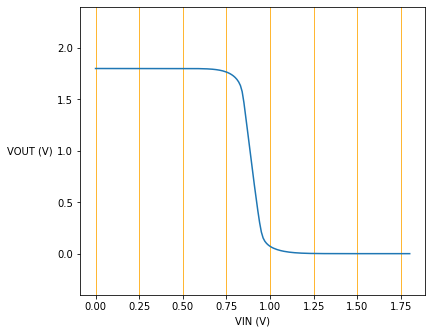

In [14]:
pwr()  # Apply power to the circuitry.

inv = inverter()  # Create an inverter.

# Attach a voltage source between ground and the inverter's input.
# Then attach the output to a net.
gnd & V(ref="VIN", dc_value=0.0@u_V)["n, p"] & Net("VIN") & inv["a, out"] & Net("VOUT")

# Do a DC-level simulation while ramping the voltage source from 0 to Vdd.
vio = do_dc(VIN=slice(0, vdd_voltage, 0.01))

# Plot the inverter's output against its input.
oscope(vio, inv.a, inv.out)

For a low-level input, the inverter's output is high and vice-versa as expected. From the shape of the transfer curve, I'd estimate the inverter's trigger point is around 0.8V.

It's also interesting to look at the current draw of the inverter as the input voltage ramps up:

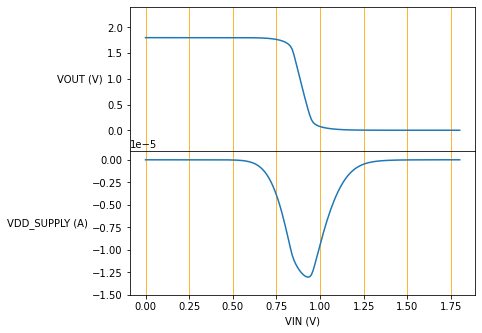

In [15]:
# Add a trace for the Vdd power supply current.
disp_imin, disp_imax = -15@u_uA, 1@u_uA
oscope(vio, inv.a, inv.out, vdd_ps)

As we learned in our textbooks so long ago, the quiescent current for CMOS logic is near zero but surges as the input voltage goes through the transition zone when both transistors are ON. For this inverter, the current maxes-out at about 13 $\mu$A at the trigger point.

It's equally easy to do a transient analysis of the inverter as it receives an input that varies over time:


No errors or warnings found during netlist generation.



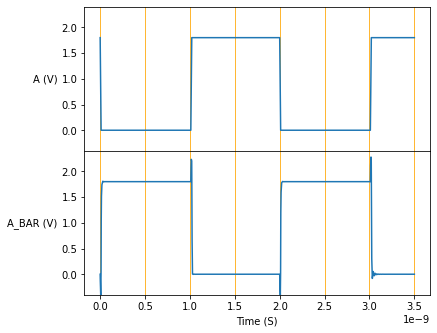

In [16]:
pwr()

# Connect a 500 MHz square wave to net A.
a = Net("A")
cntgen(a)

# Pump the square wave through an inverter.
inv = inverter()
a & inv["a, out"] & Net("A_BAR")

# Do a transient analysis and look at the timing between input and output.
waveforms = do_trans(step_time=0.01@u_ns, end_time=3.5@u_ns)
oscope(waveforms, a, inv.out)

There is a bit of ringing on the inverter's output but no appreciable propagation delay, probably because there is no real load on the output. In order to get more delay, I'll cascade thirty inverters together and look at the output of the last one:


No errors or warnings found during netlist generation.



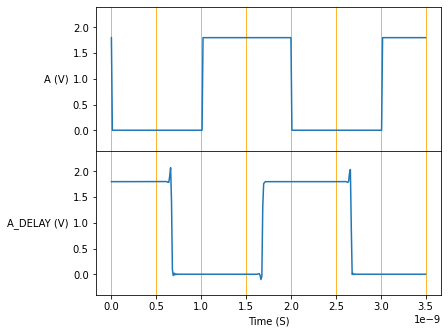

In [17]:
pwr()

a = Net("A")
cntgen(a)

# Create a list of 30 inverters.
invs = [inverter() for _ in range(30)]

# Attach the square wave to the first inverter in the list.
a & invs[0].a

# Go through the list, attaching the input of each inverter to the output of the previous one.
for i in range(1, len(invs)):
    invs[i-1].out & invs[i].a
    
# Attach the output of the last inverter to the output net.
invs[-1].out & Net("A_DELAY")

# Do a transient analysis.
waveforms = do_trans(step_time=0.01@u_ns, end_time=3.5@u_ns)
oscope(waveforms, a, invs[-1].out)

Thirty cascaded inverters creates a total delay of around 0.65 ns, so each inverter contributes about 20 ps. This simulation doesn't include things like wiring delays, so don't get your hopes up about running at 50 GHz.

Finally, just to test the `how_big` function, let's see how many transistors are in 30 inverters:

In [18]:
how_big()

V: 1
PULSEV: 1
sky130_fd_pr__pfet_01v8: 30
sky130_fd_pr__nfet_01v8: 30


Thirty NMOS and thirty PMOS transistors. We're good to go.

## The Universal: the NAND Gate

They say if you have a NAND gate, you have it all (if all you want is combinational logic, which seems a bit limited). Here's the schematic for one:

![CMOS NAND gate schematic](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.allaboutcircuits.com%2Fuploads%2Farticles%2FCMOS-NAND-gate-schematic-diagram.jpg&f=1&nofb=1)

And this is its SKiDL version:

In [19]:
@package
def nand(a=Net(), b=Net(), out=Net()):
    # Create the PFET and NFET transistors.
    q1, q2 = 2 * pfet()
    q3, q4 = 2 * nfet()
    
    # Connect the PFET/NFET substrates to Vdd/gnd, respectively.
    vdd & q1.b & q2.b
    gnd & q3.b & q4.b
    
    # Go from Vdd through a parallel-pair of PFETs to the output and then
    # through a series-pair of NFETs to ground.
    vdd & (q1["s,d"] | q2["s,d"]) & out & q3["d,s"] & q4["d,s"] & gnd
    
    # Connect the pair of inputs to the gates of the transistors.
    a & q1.g & q3.g
    b & q2.g & q4.g

Like with the inverter, I'll do a transient analysis but using two square waves to drive both NAND inputs:


No errors or warnings found during netlist generation.



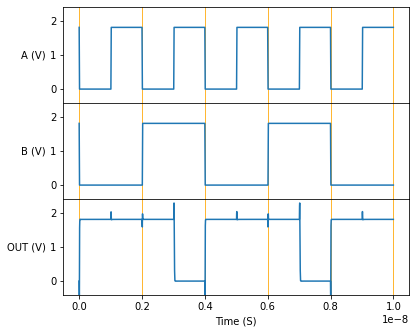

In [20]:
pwr()

a, b, out = Net("A"), Net("B"), Net("OUT")

# Create two square waves: a at 500 MHz and b at 250 MHz.
cntgen(a, b)

# Create a NAND gate and connect its I/O to the nets.
nand()["a, b, out"] += a, b, out

# Perform a transient analysis.
waveforms = do_trans(step_time=0.01@u_ns, end_time=10@u_ns)
oscope(waveforms, a, b, out)

The NAND gate output only goes low when both inputs are high, as expected. Ho hum.

## One or the Other: the XOR Gate

Continuing on, here is the last combinational gate I'll do: the exclusive-OR. There's nothing really new here that you haven't already seen with the NAND gate, just more of it.

![XOR gate](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fthumb%2Ff%2Ffa%2FCMOS_XOR_Gate.svg%2F1280px-CMOS_XOR_Gate.svg.png&f=1&nofb=1)

In [21]:
@package
def xor(a=Net(), b=Net(), out=Net()):
    # Create eight transistors: four NFETs and four PFETs.
    qn_a, qn_ab, qn_b, qn_bb = 4 * nfet()
    qp_a, qp_ab, qp_b, qp_bb = 4 * pfet()
    
    # Connect the substrates of the transistors.
    vdd & qp_a.b & qp_ab.b & qp_b.b & qp_bb.b
    gnd & qn_a.b & qn_ab.b & qn_b.b & qn_bb.b
    
    # Create the two parallel "legs" of series PFETs-NFETs with a
    # common output node in the middle.
    vdd & qp_ab["s,d"] & qp_b["s,d"] & out & qn_a["d,s"] & qn_b["d,s"] & gnd
    vdd & qp_a["s,d"] & qp_bb["s,d"] & out & qn_ab["d,s"] & qn_bb["d,s"] & gnd
    
    # Create two inverters to get the complements of both inputs.
    ab, bb = inverter(), inverter()
    ab.a += a
    bb.a += b

    # Attach the two inputs and their complements to the transistor gates.
    a      & qp_a.g  & qn_a.g
    ab.out & qp_ab.g & qn_ab.g
    b      & qp_b.g  & qn_b.g
    bb.out & qp_bb.g & qn_bb.g



No errors or warnings found during netlist generation.



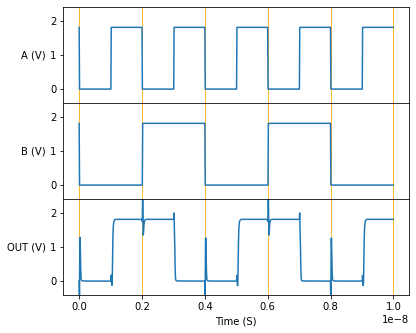

In [22]:
pwr()

a, b, out = Net("A"), Net("B"), Net("OUT")
cntgen(a, b)

xor()["a, b, out"] += a, b, out

waveforms = do_trans(step_time=0.01@u_ns, end_time=10@u_ns)
oscope(waveforms, a, b, out)

The output only goes high when the inputs have opposite values, so the XOR gate is working correctly.

## No, It's Not a Snake: The Adder

Finally I've reached the level of abstraction where individual transistors aren't needed. I can use the gates I've already built to construct new stuff, like this [full-adder bit](https://www.geeksforgeeks.org/full-adder-in-digital-logic/):

![Full adder bit](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.hv1H5z95bT2f_llqtxYglQHaEt%26pid%3DApi&f=1)

In [23]:
@package
def full_adder(a=Net(), b=Net(), cin=Net(), s=Net(), cout=Net()):
    # Use two XOR gates to compute the sum bit.
    ab_sum = Net()  # Net to carry the intermediate result of a+b.
    xor()["a,b,out"] += a, b, ab_sum    # Compute ab_sum=a+b
    xor()["a,b,out"] += ab_sum, cin, s  # Compute s=a+b+cin
    
    # Through the magic of DeMorgan's Theorem, the AND-OR carry circuit
    # can be done using three NAND gates.
    nand1, nand2, nand3 = nand(), nand(), nand()
    nand1["a,b"] += ab_sum, cin
    nand2["a,b"] += a, b
    nand3["a,b,out"] += nand1.out, nand2.out, cout

I'll use a `cntgen()` with three outputs to apply all eight input combinations to the full-adder:


No errors or warnings found during netlist generation.



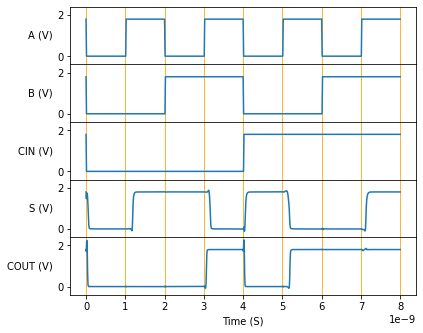

In [24]:
pwr()

# Generate nets for the inputs and outputs.
a, b, cin, s, cout = Net("A"), Net("B"), Net("CIN"), Net("S"), Net("COUT")

# Drive the A, B and CIN full-adder inputs with all eight combinations.
cntgen(a, b, cin)

# Connect the I/O nets to the full-adder.
full_adder()["a, b, cin, s, cout"] += a, b, cin, s, cout

# Do a transient analysis.
waveforms = do_trans(step_time=0.01@u_ns, end_time=8@u_ns)
oscope(waveforms, a, b, cin, s, cout)

The sum and carry-out bits of the full-adder match the truth-table for all the combinations of A, B and the carry input.

Now I'll combine multiple full-adders to build a multi-bit adder:

In [25]:
@subcircuit
def adder(a, b, cin, s, cout):
    # a, b and s are multi-bit buses. The width of the adder will
    # be determined by the length of the sum output.
    width = len(s)
    
    # Create a list of full-adders equal to the width of the sum output.
    fadds = [full_adder() for _ in range(width)]
    
    # Iteratively connect the full-adders to the input and output bits.
    for i in range(width):
        
        # Connect the i'th full adder to the i'th bit of a, b and s.
        fadds[i]["a, b, s"] += a[i], b[i], s[i]
        
        if i == 0:
            # Connect the carry input to the first full-adder.
            fadds[i].cin += cin
        else:
            # Connect the carry input of the rest of the full-adders
            # to the carry output from the previous one.
            fadds[i].cin += fadds[i-1].cout
            
    # Connect the carry output to the carry output from the last bit of the adder.
    cout += fadds[-1].cout

I'll instantiate a two-bit adder and test it with all 32 input combinations of A$_0$, A$_1$, B$_0$, B$_1$, and C$_{in}$:


No errors or warnings found during netlist generation.



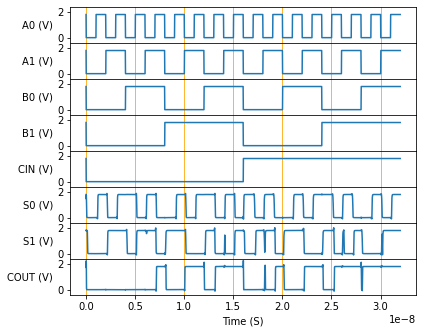

In [26]:
pwr()

# Create the two-bit input and output buses and the carry input & output nets.
w = 2
a, b, cin, s, cout = Bus("A",w), Bus("B",w), Net("CIN"), Bus("S",w), Net("COUT")

# Drive the A0, A1, B0, B1, and CIN inputs with a five-bit counter.
cntgen(*a, *b, cin)

# Connect the I/O to an adder.
adder(a, b, cin, s, cout)

# Do a transient analysis
waveforms = do_trans(step_time=0.01@u_ns, end_time=32@u_ns)
oscope(waveforms, *a, *b, cin, *s, cout)

The outputs *look* like they might be correct, but I'm not going to waste my time trying to eyeball it when Python can do that. The following code subsamples the waveforms and converts them into a table of integers for the adder's inputs and outputs:

In [27]:
def integerize(waveforms, *nets, threshold=0.9@u_V):
    """
    Convert a set of N waveforms to a stream of N-bit integer values.
    
    Args:
        waveforms: Waveform data from ngspice.
        nets: A set of nets comprising a digital word.
        threshold: Voltage threshold for determining if a waveform value is 1 or 0.
        
    Returns:
        A list of integer values, one for each sample time in the waveform data.
    """
    
    def binarize():
        """Convert multiple waveforms into streams of ones and zeros."""
        binary_vals = []
        for net in nets:
            binary_vals.append([v > threshold for v in waveforms[node(net)]])
        return binary_vals

    # Convert the waveforms into streams of bits, then combine the bits into integers.
    int_vals = []
    for bin_vector in zip(*reversed(binarize())):
        int_vals.append(int(bytes([ord('0')+b for b in bin_vector]), base=2))
    return int_vals

def subsample(subsample_times, sample_times, *int_waveforms):
    """
    Take a subset of samples from a set of integerized waveforms at a set of specific times.
    
    Args:
        subsample_times: A list of times (in ascending order) at which to take subsamples.
        sample_times: A list of times (in ascending order) for when each integerized sample was taken.
        int_waveforms: List of integerized waveform sample lists.
        
    Returns:
        A list of subsample lists.
    """
    
    # Create a list of the empty lists to hold the subsamples from each integerized waveform.
    subsamples = [[] for _ in int_waveforms]
    
    # Get the first subsample time.
    subsample_time = subsample_times.pop(0)
    
    # Step through the sample times, looking for the time to take a subsample.
    for sample_time, *samples in zip(sample_times, *int_waveforms):
        
        # Take a subsample whenever the sample time is less than the current subsample time.
        if sample_time > subsample_time:
        
            # Store a subsample from each waveform.
            for i, v in enumerate(samples):
                subsamples[i].append(v)
                
            # Get the next subsample time and break from loop if there isn't one.
            try:
                subsample_time = subsample_times.pop(0)
            except IndexError:
                break

    return subsamples

In [28]:
# Convert the waveforms for A, B, Cin, S, and Cout into lists of integers.
a_ints = integerize(waveforms, *a)
b_ints = integerize(waveforms, *b)
cin_ints = integerize(waveforms, cin)
# Combine the N-bit sum and carry-out into a single N+1-bit integer.
s_ints = integerize(waveforms, *s, cout)

# Set the subsample times just before the adder's inputs change.
ts = [(i+0.9)@u_ns for i in range(32)]

# Subsample the integerized adder waveforms.
av, bv, cinv, sv = subsample(ts, waveforms.time, a_ints, b_ints, cin_ints, s_ints)

# Display a table of the adder's inputs and corresponding output.
pd.DataFrame({'A': av, 'B': bv, 'CIN': cinv, 'S': sv})

,A,B,CIN,S
0,0,0,0,0
1,1,0,0,1
2,2,0,0,2
3,3,0,0,3
4,0,1,0,1
5,1,1,0,2
6,2,1,0,3
7,3,1,0,4
8,0,2,0,2
9,1,2,0,3


That's better, but even checking all the table entries is too much work so I'll write a little code to do that:

In [29]:
error_flag = False
for a, b, cin, s in zip(av, bv, cinv, sv):
    if a+b+cin != s:
        print(f"ERROR: {a}+{b}+{cin} != {s}")
        error_flag = True
if not error_flag:
    print("No errors found.")

No errors found.


OK, at this point I'm convinced I have a working two-bit adder. And I can make any size adder I want just by changing the input and output bus widths.

Onward!

## Fragments of Memory: Latches, Flip-Flops and Registers

Cross-coupled logic gates like this [dynamic master-slave flip-flop](http://ece-research.unm.edu/jimp/vlsi/slides/chap5_2.html) are often used for storing bits:

![Dynamic latch bit](http://ece-research.unm.edu/jimp/vlsi/slides/chap5_2-22.gif)

The SKiDL implementation for half of this flip-flop creates a latch that allows data to enter and pass through when the write-enable is active, and then latches the data bit with a feedback transistor when the write-enable is not asserted:

In [30]:
@package
def latch_bit(wr=Net(), d=Net(), out=Net()):
    
    # Create the inverters and gating transistors.
    inv_in, inv_out = inverter(), inverter()
    q_in, q_latch = nfet(), nfet()
    
    # Connect the transistor substrates.
    q_in.b & q_latch.b & gnd
    
    # Input data comes in through the input gate, goes through two inverters to the data output
    # which is fed back to the input of the cascaded inverters through the latching gate.
    d & q_in["s,d"] & inv_in["a, out"] & inv_out["a, out"] & out
    out & q_latch["d,s"] & inv_in.a  # Feed output back to input.
    
    # wr opens the input gate, and its complement controls the latching gate.
    wr & q_in.g
    wr & inverter()["a, out"] & q_latch.g


By cascading two of these latches, I arrive at the complete flip-flop:

In [31]:
@package
def ms_ff(wr=Net(), d=Net(), out=Net()):
    
    # Create the master and slave latches.
    master, slave = latch_bit(), latch_bit()
    
    # Data passes from the input through the master to the slave latch and then to the output.
    d & master["d, out"] & slave["d, out"] & out
    
    # Data continually enters the master latch when the write-enable is low, but gets 
    # latched when the write-enable goes high..
    wr & inverter()["a, out"] & master.wr
    
    # Data from the master passes through the slave when the write-enable goes high, and
    # this data stays stable in the slave when the write-enable goes low and new data 
    # is entering the master.
    wr & slave.wr

A simple test shows the flip-flop retains data and the output only changes upon the rising edge of the write-enable (after a bit of propagation delay):


No errors or warnings found during netlist generation.



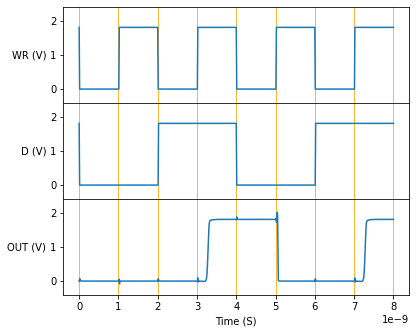

In [32]:
pwr()

wr, d, out = Net('WR'), Net('D'), Net('OUT')
cntgen(wr, d)

ms_ff()["wr, d, out"] += wr, d, out

waveforms = do_trans(step_time=0.01@u_ns, end_time=8@u_ns)
oscope(waveforms, wr, d, out)

Once I have a basic flip-flop, it's easy to build multi-bit registers:

In [33]:
@subcircuit
def register(wr, d, out):

    # Create a flip-flop for each bit in the output bus.
    reg_bits = [ms_ff() for _ in out]
    
    # Connect the inputs and outputs to the flip-flops.
    for i, rb in enumerate(reg_bits):
        rb["wr, d, out"] += wr, d[i], out[i]

## The Simplest State Machine: the Counter

With both an adder and a register in hand, a counter is the obvious next step:

In [34]:
@subcircuit
def cntr(clk, out):
    # Create two buses: one for the next counter value, and one that's all zero bits.
    width = len(out)
    nxt, zero = Bus(width), Bus(width)
    
    # Provide access to the global ground net.
    global gnd
    
    # Connect all the zero bus bits to ground (that's why it's zero).
    gnd += zero

    # The next counter value is the current counter value plus 1. Set the
    # adder's carry input to 1 and the b input to zero to do this.
    adder(a=out, b=zero, cin=vdd, s=nxt, cout=Net())
    
    # Clock the next counter value into the register on the rising clock edge.
    register(wr=clk, d=nxt, out=out)

Now just give it a clock and watch it go!


No errors or warnings found during netlist generation.



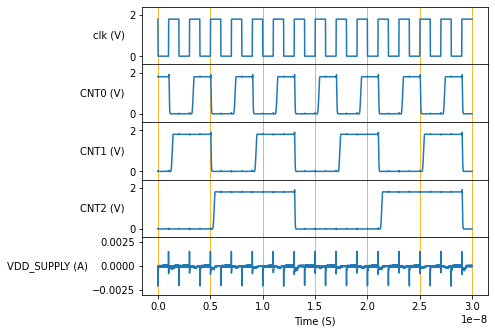

In [35]:
pwr()

# Generate a clock signal.
clk = Net('clk')
cntgen(clk)

# Create a three-bit counter.
cnt = Bus('CNT', 3)
cntr(clk, cnt)

# Simulate the counter.
waveforms = do_trans(step_time=0.01@u_ns, end_time=30@u_ns)

# In addition to the clock and counter value, also look at the power supply current.
disp_imin, disp_imax = -3@u_mA, 3@u_mA
oscope(waveforms, clk, *cnt, vdd_ps)

Looking at the counter bits shows its obviously incrementing 0, 1, 2, ..., 7, 0, ... The bottom trace shows the pulses of supply current on every clock edge. (Remember that whole current-pulse-during-input-transition thing?) But how much energy is being used? Multiplying the supply current by its output voltage and summing over time will answer that:

In [36]:
time_steps = waveforms.time[1:] - waveforms.time[0:-1]
ps_current = -waveforms[node(vdd_ps)][0:-1] # Mult by -1 to get current FROM the + terminal of the supply.
ps_voltage = waveforms[node(vdd)][0:-1]

energy = sum(ps_current * ps_voltage * time_steps)@u_J
print(f"Total energy = {energy}")

Total energy = 3.887916338945843e-12 J


In [37]:
how_big()

V: 1
PULSEV: 1
sky130_fd_pr__nfet_01v8: 87
sky130_fd_pr__pfet_01v8: 75


## Bonus: an ALU

An adder is great and all, but that's all it does: adds. Having a module that adds, subtracts, shifts, and performs logical operations is much cooler! That's an *arithmetic logic unit* (ALU).

You might think building an ALU is a lot harder than building an adder, but it's not. It can all be done using an *8-to-1 multiplexer* (mux) as the basic building block:

![8-to-1 Multiplexer](https://www.researchgate.net/profile/Senentxu_Lanceros-Mendez/publication/224311777/figure/fig4/AS:393728339529731@1470883559740/81-analog-multiplexer-circuit.png)

I can build a full-adder bit from a pair of 8-to-1 muxes by passing the A, B, and C$_{in}$ inputs as the selectors, and applying the eight-bit truth-table for the S and C$_{out}$ bits to the input of each mux, respectively. Then I'll combine the full-adder bits to build a complete $N$-bit adder as before.

But I can also build a subtractor, left-shifter, logical-AND, etc just by changing the truth-table bits that go to each mux. (If you're familiar with [FPGAs](https://en.wikipedia.org/wiki/Field-programmable_gate_array), the mux is essentially the same as their [look-up tables](https://electronics.stackexchange.com/questions/169532/what-is-an-lut-in-fpga).)

The complete SKiDL code for an ALU is shown below. (Much easier to create, thankfully, than tediously drawing the circuit shown above.)

In [38]:
@package
def tx_gate(i, g, g_b, o):
    """NMOS/PMOS transmission gate. When g is high and g_b is low, i and o are connected."""
    
    # NMOS and PMOS transistors for passing input to output.
    qn, qp = nfet(), pfet()
    
    # Transistor substrate connections.
    gnd & qn.b
    vdd & qp.b
    
    # Parallel NMOS/PMOS transistors between the input and output.
    i & (qn["s,d"] | qp["s,d"]) & o
    
    # Connect the gate input to the NMOS and the complement of the gate input
    # to the PMOS. Both transistors will conduct when the gate input is high,
    # and will block the input from the output when the gate input is low.
    g & qn.g
    g_b & qp.g
    
@package
def mux8(in_, i0=Net(), i1=Net(), i2=Net(), out=Net()):
    
    # Create the complements of the selection inputs.
    i0b, i1b, i2b = Net(), Net(), Net()
    i0 & inverter()["a,out"] & i0b
    i1 & inverter()["a,out"] & i1b
    i2 & inverter()["a,out"] & i2b

    out_ = Net()  # Output from the eight legs of the mux.
    i = 0  # Input bit index.
    
    # Create the eight legs of the mux by nested iteration of the selection inputs
    # and their complements.
    for i2_g, i2_g_b in ((i2b, i2), (i2, i2b)):
        for i1_g, i1_g_b in ((i1b, i1), (i1, i1b)):
            for i0_g, i0_g_b in ((i0b, i0), (i0, i0b)):
                
                # Place 3 transmission gates in series from input bit i to output.
                i0_gate, i1_gate, i2_gate = tx_gate(), tx_gate(), tx_gate()
                in_[i] & i0_gate["i,o"] & i1_gate["i,o"] & i2_gate["i,o"] & out_
                
                # Attach the selection inputs and their complements to the transmission gates.
                i0_gate["g, g_b"] += i0_g, i0_g_b
                i1_gate["g, g_b"] += i1_g, i1_g_b
                i2_gate["g, g_b"] += i2_g, i2_g_b
                
                i = i+1  # Go to the next input bit.
                
    # Run the output through two inverters to restore signal strength.
    out_ & inverter()["a, out"] & inverter()["a, out"] & out
                
@subcircuit
def alu(a, b, cin, s, cout, s_opcode, c_opcode):
    """
    Multi-bit ALU with the operation determined by the eight-bit codes
    that determine the output from the sum and carry muxes.
    """
    
    width = len(s)
    s_bits = [mux8() for _ in range(width)]
    c_bits = [mux8() for _ in range(width)]
    
    # For each bit in the ALU...
    for i in range(width):
        
        # Connect truth-table bits to the sum and carry mux inputs.
        s_bits[i].in_ += s_opcode
        c_bits[i].in_ += c_opcode
        
        # Connect inputs to the sum and carry mux selectors.
        s_bits[i]["i0, i1"] += a[i], b[i]
        c_bits[i]["i0, i1"] += a[i], b[i]
        
        # Connect the carry input of each ALU bit to the carry output of the previous bit.
        if i == 0:
            s_bits[i].i2 & cin
            c_bits[i].i2 & cin
        else:
            s_bits[i].i2 & c_bits[i-1].out
            c_bits[i].i2 & c_bits[i-1].out
            
        # Connect the output bit of each sum mux to the ALU sum output.
        s[i] & s_bits[i].out
        
    # Connect the carry output from the last ALU bit.
    cout & c_bits[-1].out

By setting the sum and carry opcodes appropriately, I can build a subtractor from the ALU:

In [39]:
@subcircuit
def subtractor(a, b, cin, s, cout):
    """
    Create a subtractor by applying the required opcodes to the ALU.
    """

    # Set the opcodes to perform subtraction (a - b - c), so in reality the carry
    # is actually a borrow.
    # cin  b   a   s  cout
    # ====================
    #  0   0   0   0   0
    #  0   0   1   1   0
    #  0   1   0   1   1
    #  0   1   1   0   0
    #  1   0   0   1   1
    #  1   0   1   0   0
    #  1   1   0   0   1
    #  1   1   1   1   1
    one = vdd
    zero = gnd
    s_opcode = Bus(zero, one, one, zero, one, zero, zero, one)
    c_opcode = Bus(zero, zero, one, zero, one, zero, one, one)

    # Connect the I/O and opcodes to the ALU.
    alu(a=a, b=b, cin=cin, s=s, cout=cout, s_opcode=s_opcode, c_opcode=c_opcode)


Now I'll test the subtractor just as I did previously with the adder:


No errors or warnings found during netlist generation.



,A,B,CIN,S
0,0,0,0,0
1,1,0,0,1
2,2,0,0,2
3,3,0,0,3
4,0,1,0,7
5,1,1,0,0
6,2,1,0,1
7,3,1,0,2
8,0,2,0,6
9,1,2,0,7


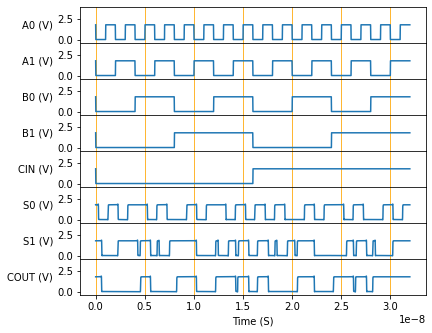

In [40]:
pwr()

# Create the two-bit input and output buses and the carry input & output nets.
w = 2
a, b, cin, s, cout = Bus("A",w), Bus("B",w), Net("CIN"), Bus("S",w), Net("COUT")

# Drive the A0, A1, B0, B1, and CIN inputs with a five-bit counter.
cntgen(*a, *b, cin)

# Connect the I/O to the subtractor.
subtractor(a=a, b=b, cin=cin, s=s, cout=cout)

# Do a transient analysis
disp_vmax = 4@u_V
waveforms = do_trans(step_time=0.01@u_ns, end_time=32@u_ns)

# Display the output waveforms.
oscope(waveforms, *a, *b, cin, *s, cout)

# Convert the waveforms for A, B, Cin, S, and Cout into lists of integers.
a_ints = integerize(waveforms, *a)
b_ints = integerize(waveforms, *b)
cin_ints = integerize(waveforms, cin)
# Combine the N-bit sum and carry-out into a single N+1-bit integer.
s_ints = integerize(waveforms, *s, cout)

# Set the subsample times right before the ALU's inputs change.
ts = [(i+0.9)@u_ns for i in range(32)]

# Subsample the integerized ALU waveforms.
av, bv, cinv, sv = subsample(ts, waveforms.time, a_ints, b_ints, cin_ints, s_ints)

# Display a table of the ALU's inputs and corresponding output.
pd.DataFrame({'A': av, 'B': bv, 'CIN': cinv, 'S': sv})

## Extra Bonus: a Down Counter

Since I went to the trouble to build a subtractor, it would be a waste if I didn't use it to make a down-counter:

In [41]:
@subcircuit
def down_cntr(clk, out):
    # Provide access to the global ground net.
    global gnd
    
    width = len(out)
    nxt, zero = Bus(width), Bus(width)
    
    gnd += zero

    # The next counter value is the current counter value minus 1. Set the
    # subtractor's borrow input to 1 and the b input to zero to do this.
    subtractor(a=out, b=zero, cin=vdd, s=nxt, cout=Net())
    
    register(wr=clk, d=nxt, out=out)


No errors or warnings found during netlist generation.



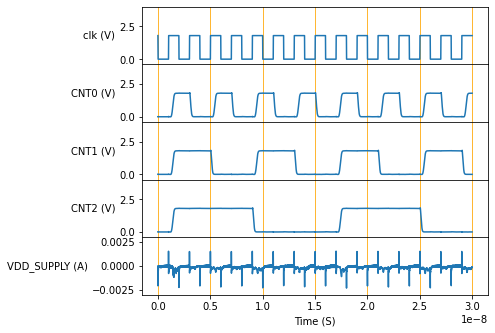

In [42]:
pwr()

clk = Net('clk')
cntgen(clk)

# Create a three-bit down counter.
cnt = Bus('CNT', 3)
down_cntr(clk, cnt)

# Simulate it.
waveforms = do_trans(step_time=0.01@u_ns, end_time=30@u_ns)
oscope(waveforms, clk, *cnt, vdd_ps)

From the waveforms, it's obvious the counter is decrementing: 7, 6, 5, ..., 0, 7, ... so chalk this one up as a win. But how does this compare to the counter I previously built using just an adder?

With regards to energy consumption, this ALU-based counter is about 2x worse (8 pJ compared to 4 pJ):

In [43]:
time_steps = waveforms.time[1:] - waveforms.time[0:-1]
ps_current = -waveforms[node(vdd_ps)][0:-1] # Mult by -1 to get current FROM the + terminal of the supply.
ps_voltage = waveforms[node(vdd)][0:-1]

energy = sum(ps_current * ps_voltage * time_steps)@u_J
print(f"Total energy = {energy}")

Total energy = 8.110961689286642e-12 J


And the ALU-based counter uses about 2.5x the number of transistors (402 versus 162):

In [44]:
how_big()

V: 1
PULSEV: 1
sky130_fd_pr__pfet_01v8: 195
sky130_fd_pr__nfet_01v8: 207


## End of the Line

OK, well that was fun.

I've gone from extracting a few transistors from the Skywater PDK all the way to constructing an ALU. And I've encapsulated that journey in this notebook so you can do it, too.

Is this the way to go about using the PDK? Possibly, if you need some detailed performance measurements on some portion of your design. But for digital designs, definitely not. Running this entire notebook takes 8 minutes and all of the designs are under 500 transistors. Using an HDL and a digital simulator would be much faster.

Now for analog designs ... maybe. SPICE lends itself to the analog domain. And I can envision using some of the functions in [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) to fine-tune analog circuits for certain performance criteria. But I haven't produced a concrete example of doing this so it remains in the realm of the imaginary. For now.
